In [1]:
# Load package
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn import model_selection
from sklearn.model_selection import KFold
from skimage.transform import resize
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
sns.set(font_scale=2) 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
import torch.utils.data
from torchsummary import summary
from torchvision.transforms.functional import rotate
from torch.utils.data import Dataset, DataLoader,TensorDataset,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import train_test_split

# device
USE_CUDA  = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f"USE CUDA {USE_CUDA}")

# reshape size
R_DIM = 40

# specified type,'Center', 'Donut', 'Edge-Ring', 'Loc', 'Scratch', 'Near-full', 'none'
TYPE_MAPPING = {
    'Center': 0,
    'Donut': 1,
    "Edge-Ring": 2,
    "Loc": 3,
    "Scratch": 4,
    "Unknown": 5,
}
NUM_CLASSES = len(TYPE_MAPPING)

# 增强参数
BASE_NOISE_PROB = 0.01   # 基础噪声强度
CONFIDENCE_THRESHOLD = 0.9  # 置信度阈值
BATCH_SIZE = 32

USE CUDA True


In [2]:
# Data
df = pd.read_pickle("./filter_size_type_LSWMD_v2.pkl.gz")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 520823 entries, 0 to 811456
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   waferMap  520823 non-null  object
 1   width     520823 non-null  int64 
 2   height    520823 non-null  int64 
 3   type      520823 non-null  object
 4   confirm   520823 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 20.4+ MB


In [3]:
df.head()

,waferMap,width,height,type,confirm
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",45,48,none,False
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",45,48,none,False
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",45,48,none,False
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",45,48,none,False
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",45,48,none,False


In [4]:
df_withpattern = df[df['type'] != 'none']
raw_train_df, raw_test_df = train_test_split(df_withpattern, test_size=0.2)

In [5]:
# 数据预处理
def preprocess_image(row, dim = R_DIM):
    """将原始图像处理为双通道40x40的numpy数组"""
    image = row.waferMap
    channel1 = (image == 1).astype(float)
    channel2 = (image == 2).astype(float)
    combined = np.stack([channel1, channel2], axis=0)  # Shape: (2, H, W)
    
    # 仅当尺寸不匹配时进行调整
    current_height, current_width = combined.shape[1], combined.shape[2]
    if current_height != dim or current_width != dim:
        # 任一维度大于目标尺寸则缩放
        if current_height > dim or current_width > dim:
            combined = resize(combined, (2, dim, dim), order=3, anti_aliasing=True)
        else:
            # 分别计算高度和宽度的填充量
            pad_h = dim - current_height
            pad_w = dim - current_width
            
            # 计算各边的填充（均匀分布，余数加在后侧）
            pad_h_before = pad_h // 2
            pad_h_after = pad_h - pad_h_before
            
            pad_w_before = pad_w // 2
            pad_w_after = pad_w - pad_w_before
            
            # 应用填充（通道维度不填充）
            combined = np.pad(combined,
                              ((0, 0),          # 通道维度
                               (pad_h_before, pad_h_after),  # 高度
                               (pad_w_before, pad_w_after))) # 宽度
    return combined  # 返回numpy数组，不直接转为Tensor


class CustomDataset(Dataset):
    images = []
    labels = []
    
    def __init__(self, wafer_list):
        for class_name, class_label in TYPE_MAPPING.items():
            class_df = df[df['type'] == class_name]
            class_samples = [row for row in class_df.itertuples()]
            N = len(class_samples)
            
            if N == 0:
                print(f"Warning: {class_name} has no samples.")
                continue
            
            augmented = []
            # 原始样本和基础增强
            for sample in class_samples:
                base_image = torch.FloatTensor(preprocess_image(sample))
                augmented.append((base_image, class_label))
                
                # 旋转增强
                for k in [1, 2, 3]:
                    rotated = torch.rot90(base_image, k, dims=[1, 2])
                    augmented.append((rotated, class_label))
                
                # 噪声增强
                noisy = self._apply_noise(base_image, BASE_NOISE_PROB)
                augmented.append((noisy, class_label))

            # 处理样本数量
            current_total = len(augmented)
            if current_total >= 4000:
                selected = np.random.choice(current_total, 4000, replace=False)
                self.images.extend([augmented[i][0] for i in selected])
                self.labels.extend([augmented[i][1] for i in selected])
            else:
                # 需要补充的样本数
                additional = 4000 - current_total
                # 使用随机增强补充
                for _ in range(additional):
                    idx = np.random.randint(N)
                    sample = class_samples[idx]
                    base_img = torch.FloatTensor(preprocess_image(sample))
                    # 随机噪声
                    noise_level = BASE_NOISE_PROB * np.random.uniform(0.5, 1.5)
                    img = self._apply_noise(base_img, noise_level)
                    augmented.append((img, class_label))
                selected = np.arange(len(augmented))  # 全部选择

            # 添加到数据集
            self.images.extend([augmented[i][0] for i in selected])
            self.labels.extend([augmented[i][1] for i in selected])
        
        assert len(self.images) == len(self.labels), "图像和标签数量不一致"

    def _apply_noise(self, image, noise_prob):
        """应用噪声到图像（非破坏性操作）"""
        noisy = image.clone()
        channel0 = noisy[0]
        noise_mask = (channel0 == 1) & (torch.rand_like(channel0) < noise_prob)
        noisy[0][noise_mask] = 0
        noisy[1][noise_mask] = 1
        return noisy
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # 转换为Tensor并发送到设备
        image = self.images[idx].to(DEVICE)
        label = torch.tensor(self.labels[idx]).to(DEVICE)
        return image, label

In [6]:
# 注意力机制
class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, channels, reduction_ratio=8):
        super().__init__()
        # 生成通道注意力权重，最终权重ChannelWeight=σ(C2(ReLU(C1(AvgPool(x)))))
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction_ratio, 1),  # 降维通道
            nn.ReLU(),
            nn.Conv2d(channels // reduction_ratio, channels, 1),  # 升维通道
            nn.Sigmoid()  # 不使用Softmax(会讲权重归一化为概率分布，适合多选一)，Sigmoid允许独立权重
        )
        # 生成空间注意力权重
        self.spatial_att = nn.Sequential(
            nn.Conv2d(2, 1, 7, padding=3),  # 融合max/avg特征，7x7 kernal
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # 通道注意力（动态调整通道重要性）
        ca = self.channel_att(x) * x
        # 空间注意力（动态调整空间重要性），最终权重SpatialWeight=σ(C([MaxPool(x);AvgPool(x)]))
        max_pool = torch.max(ca, dim=1, keepdim=True)[0]
        avg_pool = torch.mean(ca, dim=1, keepdim=True)
        sa = self.spatial_att(torch.cat([max_pool, avg_pool], dim=1)) * ca
        return sa

class DefectClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 特征提取主干，通过ReLU(x)=max(0,x)引入非线性
        self.features = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1),     # 第一层：局部特征
            nn.ReLU(),
            nn.MaxPool2d(2),                    # 最大池化，下采样
            CBAM(32),                           # 首次注意力聚焦
            nn.Conv2d(32, 64, 3, padding=1),    # 中层特征 
            nn.ReLU(),
            nn.MaxPool2d(2),                    # 最大池化，下采样
            nn.Conv2d(64, 128, 3, padding=1),   # 高层语义
            CBAM(128),                          # 二次注意力聚焦
            nn.AdaptiveAvgPool2d(1)             # 全局平均池化
        )
        # 分类头：输出节点数=num_classes
        self.classifier = nn.Sequential(
            nn.Linear(128, 256),  # 扩展特征维度
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 将多维特征图展平到一维，提供给全连接层
        return self.classifier(x)
    
    def to_device(self, device):
        self.to(device)
        return self

model = DefectClassifier(num_classes=NUM_CLASSES).to_device(DEVICE)
summary(model, (2, R_DIM, R_DIM), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 40, 40]             608
              ReLU-2           [32, 32, 40, 40]               0
         MaxPool2d-3           [32, 32, 20, 20]               0
 AdaptiveAvgPool2d-4             [32, 32, 1, 1]               0
            Conv2d-5              [32, 4, 1, 1]             132
              ReLU-6              [32, 4, 1, 1]               0
            Conv2d-7             [32, 32, 1, 1]             160
           Sigmoid-8             [32, 32, 1, 1]               0
            Conv2d-9            [32, 1, 20, 20]              99
          Sigmoid-10            [32, 1, 20, 20]               0
             CBAM-11           [32, 32, 20, 20]               0
           Conv2d-12           [32, 64, 20, 20]          18,496
             ReLU-13           [32, 64, 20, 20]               0
        MaxPool2d-14           [32, 64,

In [7]:
print(model)

DefectClassifier(
  (features): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): CBAM(
      (channel_att): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU()
        (3): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
      (spatial_att): Sequential(
        (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): Sigmoid()
      )
    )
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): CBAM(
      (channel_att): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(1

In [8]:
# 使用CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataset_train = CustomDataset(raw_train_df)
dataset_test = CustomDataset(raw_test_df)

# 创建数据加载器
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

Epoch 010 | Train Acc: 0.9756 | Test Acc: 0.9846
Epoch 020 | Train Acc: 0.9910 | Test Acc: 0.9942
Epoch 030 | Train Acc: 0.9936 | Test Acc: 0.9984
Epoch 040 | Train Acc: 0.9962 | Test Acc: 0.9933
Epoch 050 | Train Acc: 0.9968 | Test Acc: 0.9941
Epoch 060 | Train Acc: 0.9972 | Test Acc: 0.9945
Epoch 070 | Train Acc: 0.9968 | Test Acc: 0.9995
Epoch 080 | Train Acc: 0.9980 | Test Acc: 0.9995


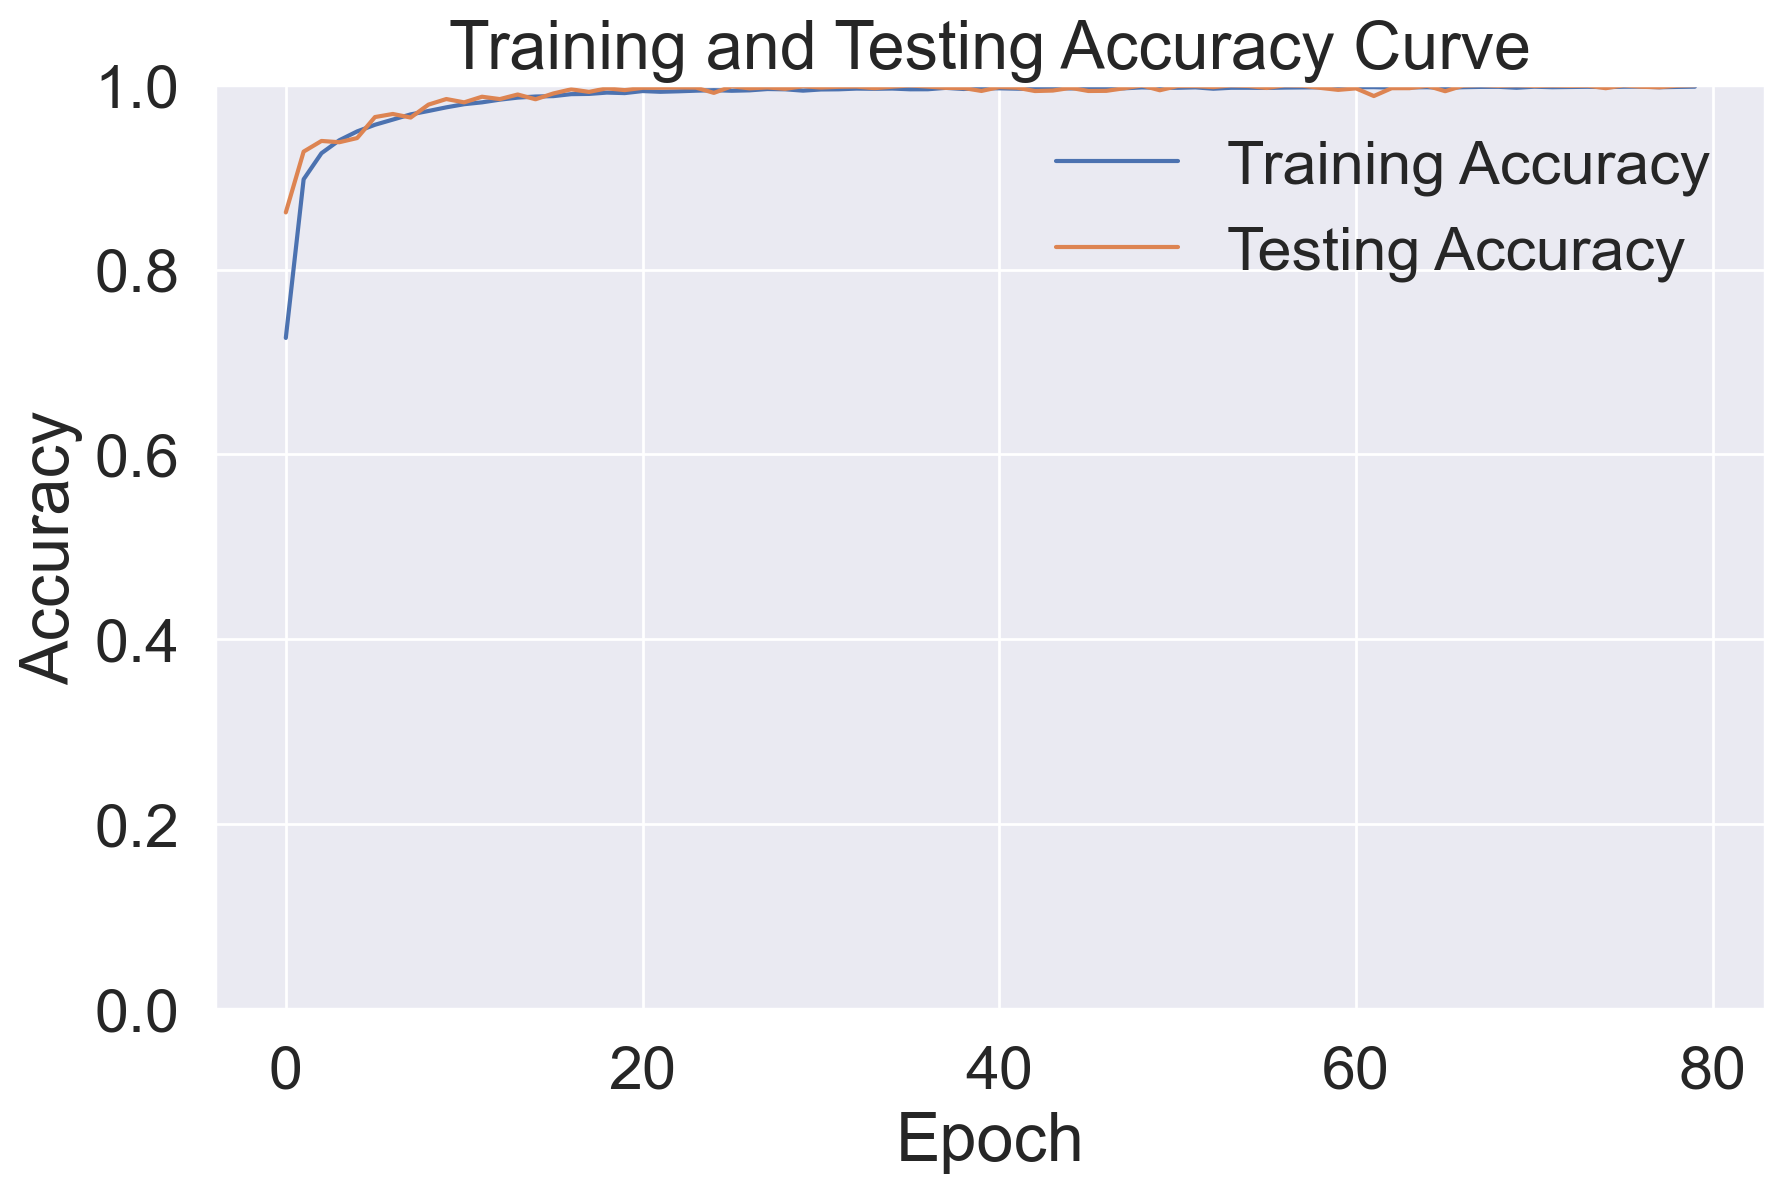

In [9]:
# 训练循环（添加准确率记录）
train_acc_history = []
test_acc_history = []

for epoch in range(80):
    # 训练阶段
    model.train()
    running_correct = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 计算训练准确率
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_train_acc = running_correct / total_samples
    train_acc_history.append(epoch_train_acc)
    
    # 测试阶段
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    
    epoch_test_acc = test_correct / test_total
    test_acc_history.append(epoch_test_acc)

    # 打印进度
    if ((epoch + 1)%10) == 0:
        print(f"Epoch {epoch+1:03d} | "
              f"Train Acc: {epoch_train_acc:.4f} | "
              f"Test Acc: {epoch_test_acc:.4f}")

# 绘制准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Testing Accuracy')
plt.title('Training and Testing Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)
plt.show()

In [14]:
model.cpu().eval()

# 使用任意batch size的示例输入（这里用batch=1演示）
example_input = torch.randn(1, 2, R_DIM, R_DIM)  # 输入维度[1,2,H,W]

# 使用trace时启用动态轴
traced_model = torch.jit.trace(
    model,
    example_input,
    strict=False,  # 允许动态维度
    check_trace=False  # 避免batch=1与训练时batch=32的中间维度校验失败
)

# 显式标记动态维度（batch维度为第0维）
traced_model = torch.jit.freeze(traced_model)
traced_model.save("dynamic_batch_model.pt")

# 验证导出成功
# 测试动态batch模型
traced_model = torch.jit.load("dynamic_batch_model.pt")

# 单样本输入
test_input = torch.randn(1, 2, R_DIM, R_DIM)
assert traced_model(test_input).shape == (1, NUM_CLASSES)

test_input_2 = torch.randn(16, 2, R_DIM, R_DIM)
assert traced_model(test_input_2).shape == (16, NUM_CLASSES)

# 原batch输入
test_batch = torch.randn(32, 2, R_DIM, R_DIM)
assert traced_model(test_batch).shape == (32, NUM_CLASSES)

In [11]:
# 测试函数示例
def predict(row, model, threshold=CONFIDENCE_THRESHOLD):
    model.eval()

    image_np = preprocess_image(row)
    image_tensor = torch.FloatTensor(image_np).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = model(image_tensor)
        prob = F.softmax(output, dim=1)
        max_prob, pred = torch.max(prob, dim=1)
        
        if max_prob.item() < threshold:
            return "unknown", max_prob.item()
        else:
            return list(TYPE_MAPPING.keys())[pred.item()], max_prob.item()

# 使用示例
# 假设test_image是一个预处理后的图像张量
# pred_type, confidence = predict(test_image, model)
# print(f"Predicted: {pred_type}, Confidence: {confidence:.4f}")

In [12]:
def save_images_from_row(row_index, row, base_dir, scale_factor=5):
    """将 waferMap 转换为 RGB 图像并保存到指定路径"""
    # 进行模型测试
    pred_type, confidence = predict(row, model)
    
    # 提取 waferMap 数据并转换为张量
    wafer_map = row['waferMap']
    wafer_tensor = torch.tensor(wafer_map, dtype=torch.long, device=DEVICE)  # Shape: (H, W)

    # 检查值范围是否合法 (0, 1, 2)
    if (wafer_tensor < 0).any() or (wafer_tensor > 2).any():
        raise ValueError(f"Row {row_index}: waferMap 值必须在 [0, 2] 范围内")

    # 将索引转换为 one-hot 编码的 RGB 图像 (H, W, 3)
    rgb_tensor = torch.zeros((*wafer_tensor.shape, 3), device=DEVICE)
    rgb_tensor.scatter_(dim=2, index=wafer_tensor.unsqueeze(-1), value=1)  # Shape: (H, W, 3)

    # 调整维度顺序为 torchvision 的格式 (C, H, W)
    rgb_tensor = rgb_tensor.permute(2, 0, 1).unsqueeze(0)  # Shape: (1, 3, H, W)
    
    # 使用插值方法放大图像，使用最近邻插值 (nearest) 来确保像素值不被改变，保留图像原始特征
    rgb_tensor = F.interpolate(rgb_tensor, scale_factor=scale_factor, mode='bicubic')  # Shape: (1, 3, H*scale_factor, W*scale_factor)

    # 直接保存图像（自动处理设备移动和归一化）
    pattern_folder = os.path.join(base_dir, pred_type)
    os.makedirs(pattern_folder, exist_ok=True)
    image_path = os.path.join(pattern_folder, f"{row_index}.png")
    torchvision.utils.save_image(
        rgb_tensor, 
        image_path,
        normalize=False,   # 数据已经是 [0, 1] 范围，无需额外归一化
        scale_each=False
    )
    
def random_test(data, base_dir, selected_num):    
    # 过滤出符合目标故障类型的行
    df_without_pattern = data[data['type'] == 'none']
    selected_samples = df_without_pattern.sample(n=selected_num)

    # 批量处理（可选：使用多线程/多进程加速）
    for idx, row in selected_samples.iterrows():
        save_images_from_row(idx, row, base_dir)


selected_num = 10000
base_dir = "all_type_model"
random_test(df, base_dir, selected_num)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same